Morgan Bauer
score_prediction.ipynb
Predicts the fantasy score of an individual NBA player for one game based on the
last 10 games using an RNN.

Import required libraries

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import csv
import pandas

Define hyperparameters

In [35]:
sampling_rate = 1
sequence_length = 10
delay = sampling_rate * (sequence_length)
batch_size = 78
buffer_size = 512
epochs = 4

Calculate normalization constants

In [31]:
# Use to calculate mean and std dev
teams = {'ATL': '0',
         'BOS': '1',
         'BRK': '2',
         'CHO': '3',
         'CHI': '4',
         'CLE': '5',
         'DAL': '6',
         'DEN': '7',
         'DET': '8',
         'GSW': '9',
         'HOU': '10',
         'IND': '11',
         'LAC': '12',
         'LAL': '13',
         'MEM': '14',
         'MIA': '15',
         'MIL': '16',
         'MIN': '17',
         'NOP': '18',
         'NYK': '19',
         'OKC': '20',
         'ORL': '21',
         'PHI': '22',
         'PHO': '23',
         'POR': '24',
         'SAC': '25',
         'SAS': '26',
         'TOR': '27',
         'UTA': '28',
         'WAS': '29'}
         
main_dir = "/Users/morganbauer/Documents/GitHub/fantasy_basketball/rnn_score_prediction/training_data"
all_fan_pts = np.zeros(23694)
all_raw_data = np.zeros((23694, 24))
fan_pts_index = 0
raw_data_index = 0
count = 0
for sub_dir in os.listdir(main_dir):
    path = f"{main_dir}/{sub_dir}"
    try:
        for file in os.listdir(path):
            if file[:4] == '2023' or file[:4] == '2024':
                file_path = f"{path}/{file}"
                with open(file_path, "r") as infile:
                    reader = csv.reader(infile)
                    games = []
                    for row in reader:
                        try:
                            row[3] = teams[row[3]]
                            for pos, elem in enumerate(row):
                                row[pos] = float(elem)
                            games.append(row)
                        except KeyError:
                            pass
                        except IndexError:
                            pass
                if len(games) > delay + 1:
                    for i, game in enumerate(games):
                        count += 1
                        all_fan_pts[fan_pts_index] = game[1]
                        all_raw_data[raw_data_index, :] = game
                        fan_pts_index += 1
                        raw_data_index += 1
    except NotADirectoryError:
        pass

num_train_samples = int(0.8 * len(all_raw_data))
num_val_samples = int(0.1 * len(all_raw_data))
num_test_samples = len(all_raw_data) - num_train_samples - num_val_samples
print("train:", num_train_samples)
print("val:", num_val_samples)
print("test:", num_test_samples)

mean = all_raw_data[:num_train_samples].mean(axis = 0)
std_dev = all_raw_data[:num_train_samples].std(axis = 0)
print("mean", mean)
print("std dev:", std_dev)

train: 18955
val: 2369
test: 2370
mean [25.78797151 22.63604326  0.500976   14.47850171  0.52007386  4.19250857
  8.87776312  0.44516059  1.26325508  3.48050646  0.27037953  1.80838829
  2.28198365  0.44997916  1.0112899   3.20532841  4.21661831  2.57483514
  0.74212609  0.45692429  1.33996307  1.96855711 11.45666051 23.98674228]
std dev: [ 4.19943884 14.79896632  0.49999905  8.65658292  0.49959688  3.32711882
  6.19428595  0.24414504  1.53138893  3.12987618  0.28908323  2.49189735
  2.93310449  0.43673813  1.33818745  2.6600284   3.33981177  2.68811973
  0.97857589  0.81257522  1.42719707  1.48487956  9.09647912 10.64887321]


Prepare dataset

In [32]:
dataset = None

for sub_dir in os.listdir(main_dir):
    path = f"{main_dir}/{sub_dir}"
    try:
        for file in os.listdir(path):
            if file[:4] == '2023' or file[:4] == '2024':
                file_path = f"{path}/{file}"
                with open(file_path, "r") as infile:
                    reader = csv.reader(infile)
                    games = []
                    for row in reader:
                        try:
                            row[3] = teams[row[3]]
                            for pos, elem in enumerate(row):
                                row[pos] = float(elem)
                            games.append(row)
                        except KeyError:
                            pass
                        except IndexError:
                            pass
                if len(games) > delay + 1:
                    fan_pts = np.zeros(len(games))
                    raw_data = np.zeros((len(games), len(games[0])))
                    for i, game in enumerate(games):
                        fan_pts[i] = game[1]
                        raw_data[i, :] = game
                    raw_data -= mean
                    raw_data /= std_dev
                    game_dataset = keras.utils.timeseries_dataset_from_array(
                        raw_data[:-delay],
                        targets = fan_pts[delay:],
                        sampling_rate = sampling_rate,
                        sequence_length = sequence_length,
                        shuffle = True,
                        batch_size = batch_size
                    )
                    if dataset is None:
                        dataset = game_dataset
                    else:
                        dataset = dataset.concatenate(game_dataset)
    except NotADirectoryError:
        pass
    if dataset is not None and len(dataset) == 300:
        break
#score_ds = dataset.shuffle(buffer_size=buffer_size)

train_dataset = dataset.take(num_train_samples)
val_dataset = dataset.skip(num_train_samples).take(num_val_samples)
test_dataset = dataset.skip(num_train_samples + num_val_samples)

Building and training the net

In [36]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout = 0.25, return_sequences = True)(inputs)
x = layers.GRU(32, recurrent_dropout = 0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])

history = model.fit(train_dataset,
                    epochs = epochs,
                    validation_data = val_dataset)

Epoch 1/4
300/300 [==============================] - 20s 52ms/step - loss: nan - mae: nan
Epoch 2/4
300/300 [==============================] - 16s 52ms/step - loss: nan - mae: nan
Epoch 3/4
300/300 [==============================] - 15s 52ms/step - loss: nan - mae: nan
Epoch 4/4
300/300 [==============================] - 16s 52ms/step - loss: nan - mae: nan


Text(0.5, 0, 'Epoch')

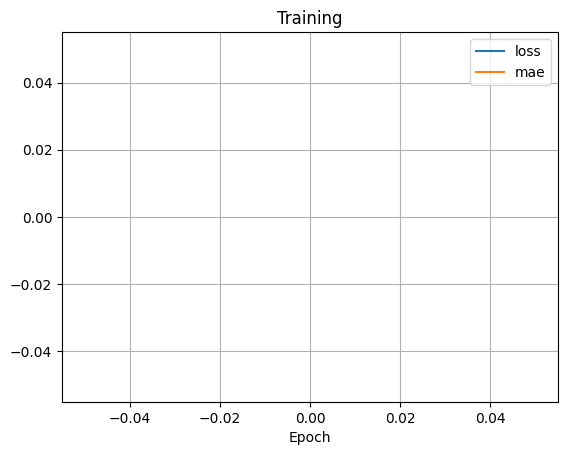

In [37]:
pandas.DataFrame(history.history).plot()
plt.grid(True)
plt.title("Training")
plt.xlabel("Epoch")